In [3]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Cell 2: UNet Model Class Definitions
# The model architecture must be defined to load the saved state_dict
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY, diffX = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, n_colors=5, bilinear=True):
        super(ConditionalUNet, self).__init__()
        self.n_channels, self.n_classes, self.n_colors, self.bilinear = n_channels, n_classes, n_colors, bilinear
        self.color_embedding = nn.Embedding(n_colors, 64)
        self.inc = DoubleConv(n_channels, 64)
        self.down1, self.down2, self.down3 = Down(64, 128), Down(128, 256), Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.color_proj = nn.Linear(64, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x, color_idx):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        color_emb = self.color_embedding(color_idx)
        color_proj = self.color_proj(color_emb)
        B, C, H, W = x5.shape
        color_proj = color_proj.view(B, C, 1, 1).expand(-1, -1, H, W)
        x5 = x5 + color_proj
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return torch.sigmoid(self.outc(x))

In [5]:
# Cell 3: Model Loading Function
def load_trained_model(model_path, device):
    """
    Load a trained model and its metadata from a checkpoint.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Checkpoint file not found: {model_path}")
        
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with the saved configuration
    model = ConditionalUNet(
        n_channels=checkpoint['model_config']['n_channels'],
        n_classes=checkpoint['model_config']['n_classes'],
        n_colors=checkpoint['model_config']['n_colors'],
        bilinear=checkpoint['model_config']['bilinear']
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    
    print(f"Model loaded from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")
    
    return model, checkpoint['color_to_idx']

# Load the best model
model_path = '/kaggle/input/ayna-model/best_model.pth'
model, color_to_idx = load_trained_model(model_path, device)
available_colors = list(color_to_idx.keys())

Model loaded from epoch 200 with validation loss: 0.0071


In [6]:
# Cell 4: Inference and Wrapper Functions

# Define the basic transform for inference images
inference_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def inference(model, input_image_path, color_name, device, color_to_idx, transform):
    """
    Perform inference on a single image.
    """
    model.eval()
    
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    
    if color_name not in color_to_idx:
        print(f"Error: Color '{color_name}' not found. Available colors: {list(color_to_idx.keys())}")
        return None, input_image
    
    color_idx_tensor = torch.tensor([color_to_idx[color_name]], dtype=torch.long).to(device)
    
    with torch.no_grad():
        prediction = model(input_tensor, color_idx_tensor)
    
    pred_np = prediction.squeeze(0).cpu().permute(1, 2, 0).numpy()
    pred_np = np.clip(pred_np, 0, 1)
    pred_image = Image.fromarray((pred_np * 255).astype(np.uint8))
    
    return pred_image, input_image

def color_polygon(input_image_path, desired_color):
    """
    User-friendly function to color a polygon and display the result.
    """
    print(f"\n🎨 Processing: Coloring '{os.path.basename(input_image_path)}' with '{desired_color}'...")
    
    if not os.path.exists(input_image_path):
        print(f"❌ Error: File '{input_image_path}' not found!")
        return
        
    # Get prediction using the globally loaded model
    colored_image, original_image = inference(
        model, input_image_path, desired_color, device, 
        color_to_idx, inference_transform
    )
    
    if colored_image is None:
        return
        
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Input Polygon')
    axes[0].axis('off')
    
    axes[1].imshow(colored_image)
    axes[1].set_title(f'Colored Output: {desired_color.capitalize()}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Available colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']

🎨 Processing: Coloring 'star.png' with 'yellow'...


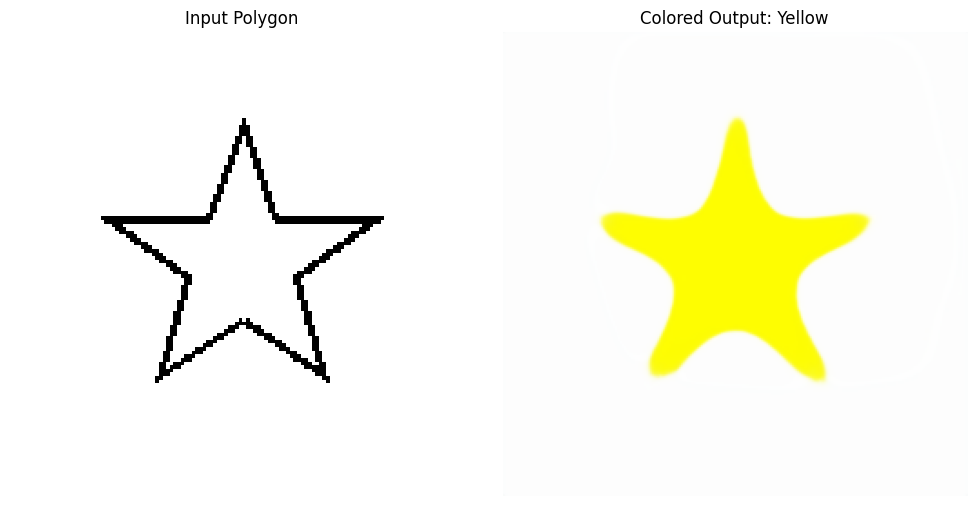

In [7]:
# Cell 5: Demonstration on a Validation Image

print("Available colors:", available_colors)

# --- Use your provided validation path ---
validation_dir = "/kaggle/input/aynadataset/dataset/dataset/validation"
sample_image_path = os.path.join(validation_dir, "inputs/star.png")

if os.path.exists(sample_image_path):
    color_polygon(sample_image_path, 'yellow')
else:
    print(f"Validation image not found at {sample_image_path}. Please check the path.")


🎨 Processing: Coloring 'star.png' with 'blue'...


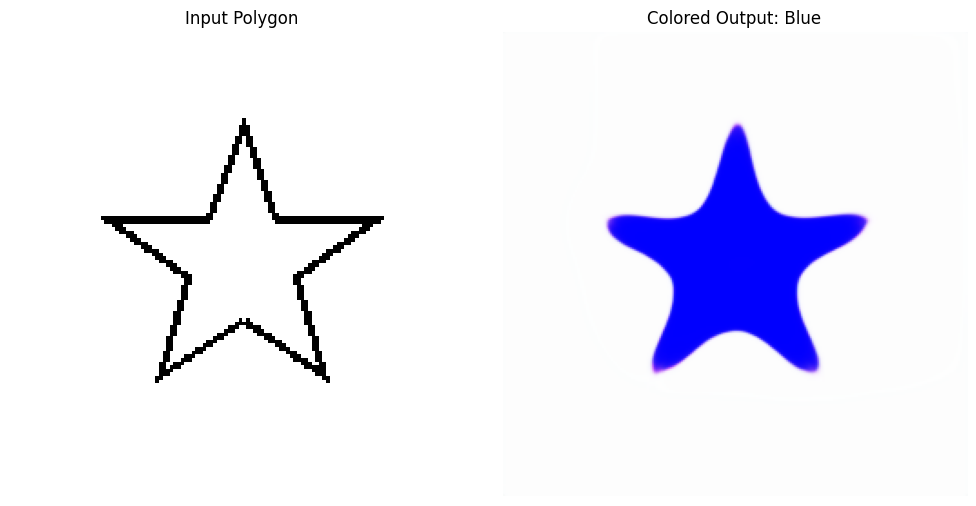


🎨 Processing: Coloring 'star.png' with 'green'...


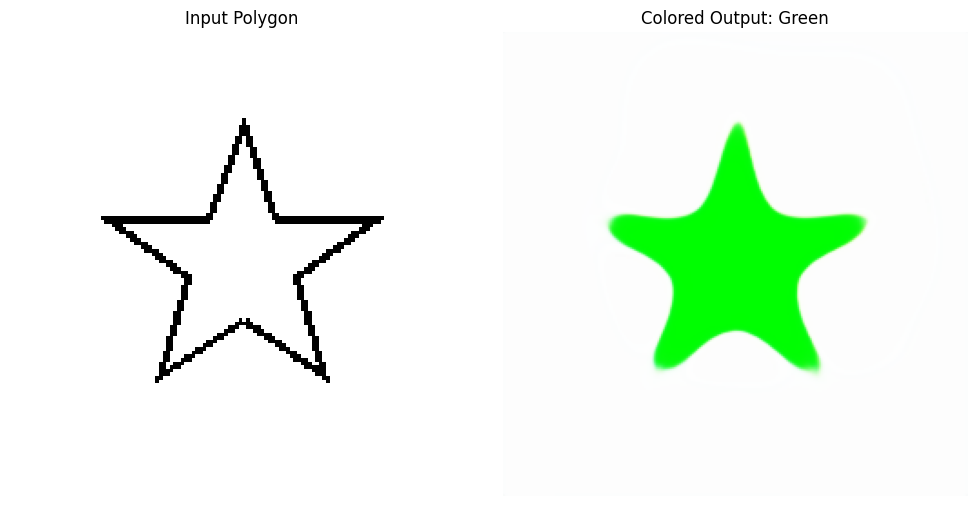

In [9]:
# Cell 6: Demonstration of Multiple Colors on the Same Shape

if os.path.exists(sample_image_path):
    color_polygon(sample_image_path, 'blue')
    color_polygon(sample_image_path, 'green')
else:
    print(f"Validation image not found at {sample_image_path}. Skipping multi-color test.")


🎨 Processing: Coloring 'octagon.png' with 'cyan'...


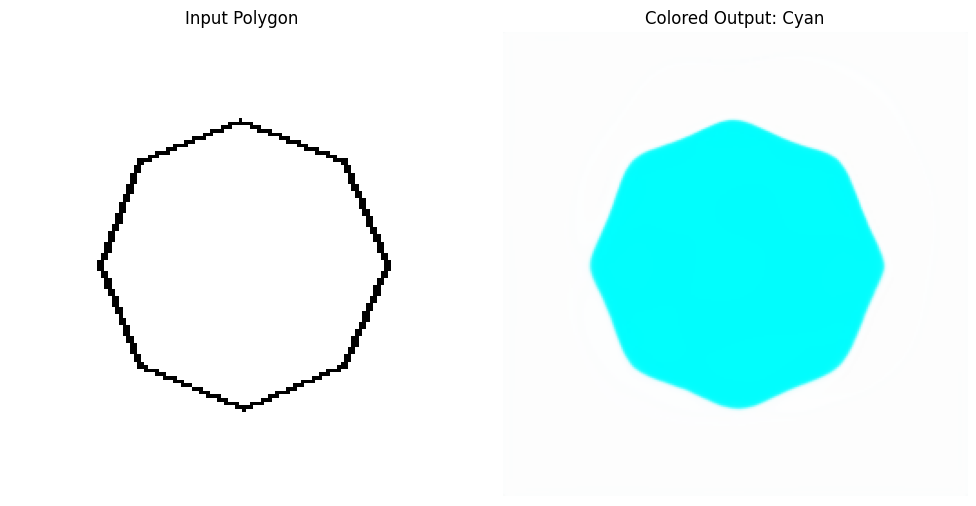

In [10]:
# Cell 7: Test Your Own Image

# 1. & 2. Set the path to your image
my_image_path = "/kaggle/input/aynadataset/dataset/dataset/validation/inputs/octagon.png" 

# 3. Choose a color
my_color = "cyan"

# 4. Run the function
color_polygon(my_image_path, my_color)